In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

keras = tf.contrib.keras

# Hotdog-not-Hotdog
>What would you say if I told you there is a app on the market that tell you if you have a hotdog or not a hotdog. 

## Transfer Learning w/ ImageNet VGG
Using a prior VGG network trained on ImageNet, we will use the convolutional layers of the VGG as feature extractors for a new classifier. The features extracted by the convolutional layers (a tensor) will serve as inputs to our much smaller (and easier to train), bespoke network.

In [2]:
# Load pre-trained VGG model
vgg16 = keras.applications.VGG16(weights = 'imagenet',
                                 input_shape = (224, 224, 3)) # 224 x 224 RGB images

553328640/553467096 [============================>.] - ETA: 0s

## Make Predictions w/ Pre-trained Model
Demonstration of out-of-the-box capabilities with the pre-trained VGG model using novel (out-of-sample) images.

In [3]:
def make_prediction(img_filename):
    image = keras.preprocessing.image.load_img(img_filename, target_size = (224, 224))
    
    # Normalize/pre-process image
    img_mat = keras.preprocessing.image.img_to_array(image)
    img_mat = np.expand_dims(img_mat, axis = 0)
    
    img_mat = keras.applications.vgg16.preprocess_input(img_mat)
    
    # Make prediction
    predictions = vgg16.predict(img_mat)
    result = keras.applications.vgg16.decode_predictions(predictions, top = 3)[0]
    
    print('Predictions:')
    #print(keras.applications.vgg16.decode_predictions(predictions))
    for i, (imagenet_id, label, prob) in enumerate(result):
        print("{} - {} ({})".format(i, label, prob))

def plot_image(img_filename):
    fig = plt.figure(figsize = (8, 8))
    
    image = keras.preprocessing.image.load_img(img_filename)

    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    ax.imshow(image)
    plt.show()
    plt.close(fig)

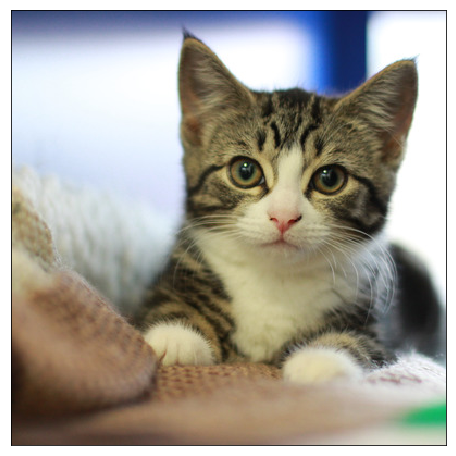

24576/35363 [===================>..........] - ETA: 0sPredictions:
0 - tabby (0.5096054077148438)
1 - Egyptian_cat (0.32073351740837097)
2 - tiger_cat (0.0897824689745903)


In [4]:
img_file = 'samples/cat.jpg'
plot_image(img_file)
make_prediction(img_file)

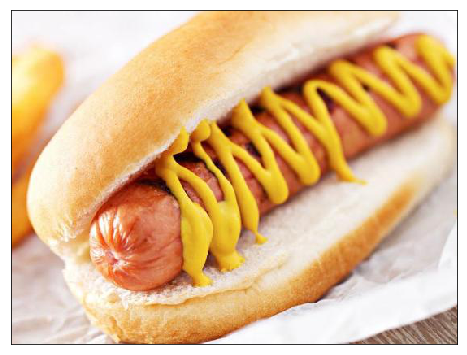

Predictions:
0 - hotdog (0.9996780157089233)
1 - cheeseburger (0.00020577930263243616)
2 - French_loaf (9.652264270698652e-05)


In [5]:
img_file = 'samples/hotdog.jpg'
plot_image(img_file)
make_prediction(img_file)

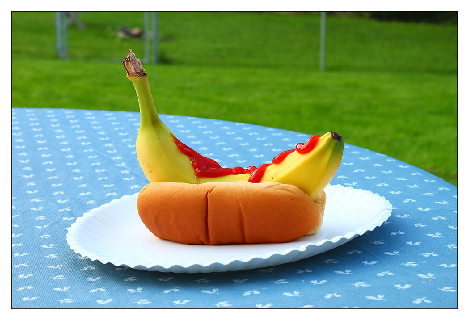

Predictions:
0 - candle (0.24211931228637695)
1 - matchstick (0.12503771483898163)
2 - golf_ball (0.0935526043176651)


In [6]:
img_file = 'samples/banana_with_ketchup.jpg'
plot_image(img_file)
make_prediction(img_file)

## Use Model for Feature Extraction
We'll re-load the pre-trained VGG but exclude the top dense layers so that we may re-train for our application.

We'll use some synsets from ImageNet to generate a two-class training and test set (positive and negative).

In [7]:
# Re-load the pre-trained model but exclude the top dense layers
model_base = keras.applications.VGG16(include_top = False, weights = 'imagenet')

58671104/58889256 [============================>.] - ETA: 0s

In [8]:
# TODO: Add more negative synsets (plants, mountains, structures, furniture,  etc.)
synset_urls = {
    'hotdog': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n07697537',
    'chili-dog': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n07865105',
    'frankfurter': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n07690019',
    'pets': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n01318894',
    'food': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n00021265',
    'people': 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n07942152'
}

positive_synsets = ['hotdog', 'chili-dog', 'frankfurter']
negative_synsets = ['pets', 'food', 'people']

In [9]:
import urllib
import urllib.request
import os

# Fetch ImageNet synset pages and store images described on those pages into corresponding directories locally
def download_imagenet_synsets(basedir, synset_urls, input_shape = (150, 150), maxresults = 100, filesize_threshold_bytes = 10240):
    for synset_key, synset_url in synset_urls.items():
        download_imagenet_synset_helper(basedir, synset_key, synset_url, maxresults, input_shape, filesize_threshold_bytes)

def download_imagenet_synset_helper(basedir, synset_key, synset_url, maxresults, input_shape, filesize_threshold_bytes):
    img_count = 1
    folder = os.path.join(basedir, synset_key)
    os.makedirs(folder, exist_ok = True)

    img_urls = str(urllib.request.urlopen(synset_url).read())
    for url in img_urls.split('\\n'):
        try:
            filename = os.path.join(folder, str(img_count) + '.jpg')
            if not os.path.isfile(filename):
                urllib.request.urlretrieve(url, filename)
                img = keras.preprocessing.image.load_img(filename, target_size = input_shape)
            
                # Flickr and other photo sharing sites will sometimes return a small, low-res "404 image" instead of a 404 HTTP code
                # We can ignore these by inspecting the size of the file on disk
                statinfo = os.stat(filename)
                if statinfo.st_size > filesize_threshold_bytes:
                    img_count += 1
                else:
                    print('Ignoring invalid image: ', url)
                    os.remove(filename)
            else:
                img_count += 1

        except urllib.error.URLError:
            # Silently ignore 4xx URL errors
            pass

        except Exception as e:
            # Probably a corrupted image or non-image data at URL
            print('Error: ', url)
            print(str(e))

        if img_count > maxresults:
            return

In [10]:
# Load a local directory of images as a Numpy array
def load_data_array(img_files, input_shape):
    images = []
    for filename in img_files:
        try:
            # Resize images for consistent dims
            image = keras.preprocessing.image.load_img(filename, target_size = input_shape)

            # Normalize/pre-process image
            img_mat = keras.preprocessing.image.img_to_array(image)
            img_mat = np.expand_dims(img_mat, axis = 0)
            img_mat = keras.applications.vgg16.preprocess_input(img_mat)

            images.append(img_mat)
        except Exception as e:
            print('Error: ', filename)
            print(str(e))
            continue

    # Convert to a Numpy array with shape (num_images, image_width, image_height, channels)
    images = np.asarray(images).squeeze(axis = 1)
    return images

In [11]:
import zipfile

# 400 images per class, 75% in training and 25% in test
num_training_per_class = 300
num_testing_per_class = 100
images_per_class = num_training_per_class + num_testing_per_class

input_shape = (150, 150, 3) # Resize images to 150x150 pixel RGB images
batch_size = 10

if os.path.isfile('imagenet_images.zip') and not os.path.exists('data/'):
    os.makedirs('data/')
    zip_ref = zipfile.ZipFile('imagenet_images.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()
else:
    download_imagenet_synsets('data/', synset_urls, input_shape = input_shape, maxresults = images_per_class)

# Split the downloaded images into training and testing sets
# TODO: Use a data generator to distort images in order to get more training examples for each class
positive_files = []
for synset in positive_synsets:
    positive_files += [os.path.join('data/', synset, f) for f in os.listdir(os.path.join('data/', synset))]

positive_training_data = load_data_array(positive_files[:(len(positive_synsets) * num_training_per_class)], input_shape)
positive_testing_data = load_data_array(positive_files[-(len(positive_synsets) * num_testing_per_class):], input_shape)

negative_files = []
for synset in negative_synsets:
    negative_files += [os.path.join('data/', synset, f) for f in os.listdir(os.path.join('data/', synset))]

negative_training_data = load_data_array(negative_files[:(len(negative_synsets) * num_training_per_class)], input_shape)
negative_testing_data = load_data_array(negative_files[-(len(negative_synsets) * num_testing_per_class):], input_shape)

In [12]:
# Extracts features from a set of images and exports as a compressed npz file
def extract_vgg_features(model, images, filename, batch_size = 10):
    extracted_features = model.predict(images, batch_size = batch_size)
    np.savez_compressed(open(filename, 'wb'), features = extracted_features)

# Loads previously exported features from a compressed npz file
def load_features(filename):
    data = np.load(open(filename, 'rb'))
    features = data['features']
    data.close
    
    return features

In [13]:
positive_training_file = 'training_positive.npz'
negative_training_file = 'training_negative.npz'
positive_testing_file = 'testing_positive.npz'
negative_testing_file = 'testing_negative.npz'

checklist = []
for f in [positive_training_file, negative_training_file, positive_testing_file, negative_testing_file]:
    checklist.append(os.path.isfile(f))

if not all(checklist):
    extract_vgg_features(model_base, positive_training_data, positive_training_file, batch_size)
    extract_vgg_features(model_base, negative_training_data, negative_training_file, batch_size)
    extract_vgg_features(model_base, positive_testing_data, positive_testing_file, batch_size)
    extract_vgg_features(model_base, negative_testing_data, negative_testing_file, batch_size)

## Use Extracted Features for New Application
Using the convolutional layers from a VGG trained on ImageNet, we use the ImageNet synsets processed above to extract features specific to 'hotdog' and (miscellaneous) 'not-hotdog' for our new classifier.

In [14]:
model_params = {
    'input_shape': (4, 4, 512), # Note that input shape is a feature tensor emitted by VGG16, NOT an image
    'dense_layers': 256
}

hyperparams = {
    'dropout': 0.6,
    'learning_rate': 0.0001,
    'epochs': 25 # TODO: Optimize network to convergence instead of fixed number of epochs
}

In [15]:
# Construct a dense neural net with 3 hidden layers
def dnn_classifier(model_params, hyperparams):
    # Input layer
    inputs = keras.layers.Input(shape = model_params['input_shape'])
    
    # Flattening layer
    net = keras.layers.Flatten()(inputs)
    
    # Fully-connected layer
    net = keras.layers.Dense(model_params['dense_layers'], activation = tf.nn.relu)(net)
    
    # Dropout layer
    net = keras.layers.Dropout(hyperparams['dropout'])(net)
    
    # Output layer w/ binary classification
    outputs = keras.layers.Dense(1, activation = tf.nn.sigmoid)(net)
    
    # Model
    model = keras.models.Model(inputs = inputs, outputs = outputs)
    
    return model

def compile_model(model, hyperparams):
    optimizer = keras.optimizers.RMSprop(lr = hyperparams['learning_rate'])
    
    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [keras.metrics.binary_accuracy])
    
    print(model.summary())
    
    return model

In [16]:
dnn = dnn_classifier(model_params, hyperparams)
dnn = compile_model(dnn, hyperparams)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


## VGG Transfer Learning Model Training
Using features extracted from the pre-trained VGG we will now train our new DNN model.

In [17]:
# Load training sets
positive_training_features = load_features(positive_training_file)
negative_training_features = load_features(negative_training_file)

# Generate training labels vector
training_features = np.vstack((positive_training_features, negative_training_features))
training_labels = np.array([1] * positive_training_features.shape[0] +
                           [0] * negative_training_features.shape[0])

# Shape: (num_images, layer_width, layer_height, layer_depth)
print('Training set shape: ', training_features.shape)

# Load testing sets
positive_testing_features = load_features(positive_testing_file)
negative_testing_features = load_features(negative_testing_file)

# Generate testing labels vector
testing_features = np.vstack((positive_testing_features, negative_testing_features))
testing_labels = np.array([1] * positive_testing_features.shape[0] +
                          [0] * negative_testing_features.shape[0])

# Shape: (num_images, layer_width, layer_height, layer_depth)
print('Testing set shape: ', testing_features.shape)

Training set shape:  (1800, 4, 4, 512)
Testing set shape:  (600, 4, 4, 512)


In [18]:
# Train the new model
# TODO: Use data augmentation
history = dnn.fit(x = training_features,
                  y = training_labels,
                  batch_size = batch_size,
                  verbose = 2,
                  epochs = hyperparams['epochs'],
                  validation_data = (testing_features, testing_labels))

Train on 1800 samples, validate on 600 samples
Epoch 1/25
2s - loss: 3.2438 - binary_accuracy: 0.7417 - val_loss: 0.4952 - val_binary_accuracy: 0.9500
Epoch 2/25
2s - loss: 1.6432 - binary_accuracy: 0.8622 - val_loss: 0.6885 - val_binary_accuracy: 0.9367
Epoch 3/25
2s - loss: 1.3560 - binary_accuracy: 0.8894 - val_loss: 0.6447 - val_binary_accuracy: 0.9517
Epoch 4/25
2s - loss: 1.1677 - binary_accuracy: 0.9017 - val_loss: 0.7304 - val_binary_accuracy: 0.9383
Epoch 5/25
2s - loss: 1.0467 - binary_accuracy: 0.9156 - val_loss: 0.9206 - val_binary_accuracy: 0.9267
Epoch 6/25
2s - loss: 0.8974 - binary_accuracy: 0.9272 - val_loss: 0.8574 - val_binary_accuracy: 0.9333
Epoch 7/25
2s - loss: 0.7656 - binary_accuracy: 0.9378 - val_loss: 0.7454 - val_binary_accuracy: 0.9450
Epoch 8/25
2s - loss: 0.7006 - binary_accuracy: 0.9417 - val_loss: 0.9802 - val_binary_accuracy: 0.9250
Epoch 9/25
2s - loss: 0.6450 - binary_accuracy: 0.9456 - val_loss: 0.8351 - val_binary_accuracy: 0.9350
Epoch 10/25
2s - 

## Transfer Learning Model Testing
Evaluate the new VGG's performance using test data.

In [19]:
# Evaluate model on batches
# TODO: Use data augmentation
loss, accuracy = dnn.evaluate(testing_features, testing_labels, batch_size = batch_size, verbose = 1)

print('\n')
print('Loss: ', loss)
print('Accuracy: ', accuracy)

380/600 [==================>...........] - ETA: 0s

Loss:  0.804970367952
Accuracy:  0.936666661501


## Plot Accuracy and Loss Over Time
Graph the `binary accuracy` and `loss` for both the training and test sets from the training performed above.

In [20]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize = (15, 10))
    
    # Training and Test set accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('VGG Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training set', 'test set'], loc='upper left')
    
    # Training and Test set loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('VGG Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training set', 'test set'], loc='upper right')
    
    plt.show()

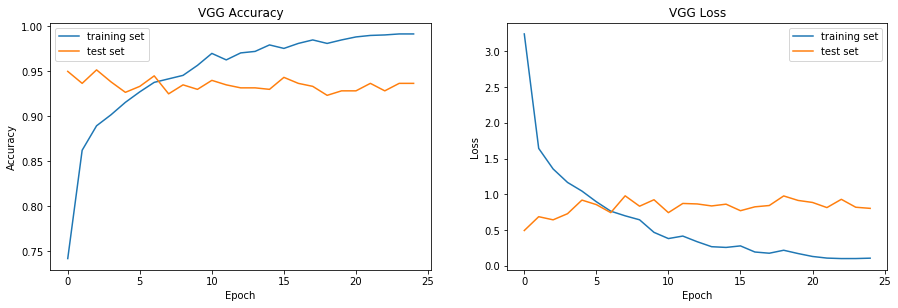

In [21]:
plot_accuracy_and_loss(history)

## Make Predictions with Model
Demonstration of classification using our new VGG.

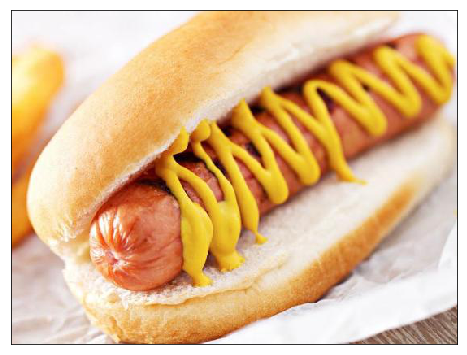



Predicted Class: 1
Predicted Label: hotdog


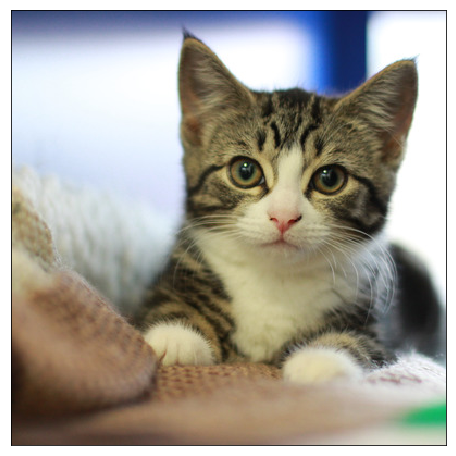



Predicted Class: 0
Predicted Label: not hotdog


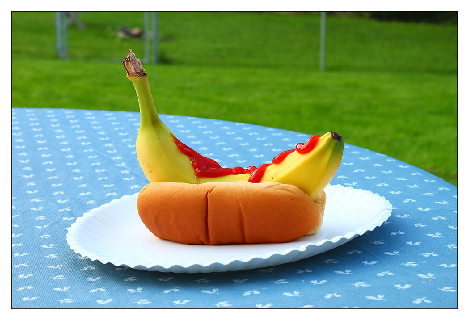



Predicted Class: 1
Predicted Label: hotdog


In [22]:
validation_img_files = ['samples/hotdog.jpg', 'samples/cat.jpg', 'samples/banana_with_ketchup.jpg']
validation_data = load_data_array(validation_img_files, input_shape)
validation_file = 'validation.npz'
if not os.path.isfile(validation_file):
    extract_vgg_features(model_base, validation_data, validation_file, batch_size = batch_size)
validation_features = load_features(validation_file)

class_probabilities = dnn.predict(validation_features)
predictions = class_probabilities.flatten().astype(int)

labels = ['not hotdog', 'hotdog']

img_idx = 0
for prediction in predictions:
    plot_image(validation_img_files[img_idx])

    print("\n")
    print("Predicted Class: {}".format(prediction))
    print("Predicted Label: {}".format(labels[prediction]))
    
    img_idx +=1

In [23]:
# Export model
model_json = dnn.to_json()
open('dnn_model.json', 'w').write(model_json)
dnn.save_weights('dnn_weights.h5', overwrite = True)